<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/MLP/MLPClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tqdm import trange
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

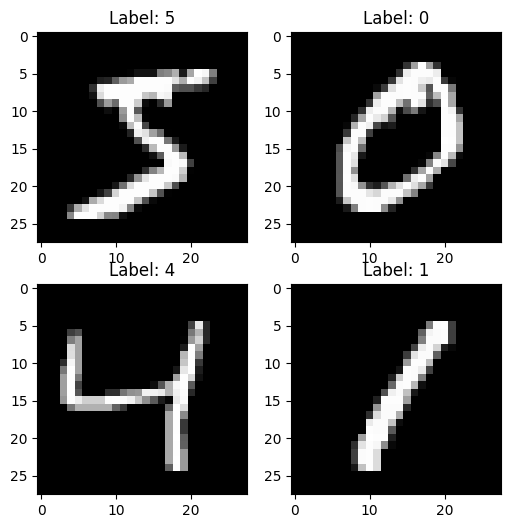

In [177]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    X_train = X_train.reshape([X_train.shape[0], -1])
    X_val = X_val.reshape([X_val.shape[0], -1])
    X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [178]:
class Layer:
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        num_units = input.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input)

In [179]:
class ReLU(Layer):
    def forward(self, input):
        return np.maximum(input, 0)

    def backward(self, input, grad_output):
        return grad_output * (input > 0)

In [180]:
class Dense(Layer):
    def __init__(self, n_inputs, n_outputs, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0,
                                        scale=np.sqrt(2/(n_inputs+n_outputs)),
                                        size=(n_inputs, n_outputs))

    def forward(self, input):
        return np.dot(input, self.weights)

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)

        assert grad_weights.shape == self.weights.shape

        self.weights = self.weights - self.learning_rate * grad_weights

        return grad_input


In [181]:
def softmax_crossentropy_with_logits(logits, target):
    logits_for_answers = logits[:, target]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits, target):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), target] = 1

    softmax = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [182]:
class MLP:

    def __init__(self):
        self.network = []

    def add_layer(self, layer, hidden=True):
        self.network.append(layer)
        if hidden: self.network.append(ReLU())

    def forward(self, X):
        activations = []
        input = X

        for layer in self.network:
            activations.append(layer.forward(input))
            input = activations[-1]


        assert len(activations) == len(self.network)

        return activations

    def predict(self, X):
        logits = self.forward(X)[-1]
        return np.argmax(logits, axis=-1)

    def fit(self, X, y):

        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        logits = layer_activations[-1]

        self.loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]

            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)

        return self.loss

    def print_layers(self):
        count = 0
        count_layer = 1
        for index, layer in enumerate(self.network):
            if count%2 == 0:
                print(f'Layer {count_layer} shape: {layer.weights.shape}')
                count_layer += 1
            count +=1

In [183]:
model = MLP()
model.add_layer(Dense(X_train.shape[1], 200))
model.add_layer(Dense(200, 200))
model.add_layer(Dense(200, 100))
model.add_layer(Dense(100, 10), hidden=False)
model.print_layers()

Layer 1 shape: (784, 200)
Layer 2 shape: (200, 200)
Layer 3 shape: (200, 100)
Layer 4 shape: (100, 10)


In [184]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)

    if shuffle: indices = np.random.permutation(len(inputs))

    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle: excerpt = indices[start_idx:start_idx + batchsize]
        else: excerpt = slice(start_idx, start_idx + batchsize)

        yield inputs[excerpt], targets[excerpt]

def train_epochs(X_train, y_train, model, X_val, y_val):
    train_log = []
    val_log = []
    print("Untrained network")
    print("Train accuracy:",np.mean(model.predict(X_train)==y_train))
    print("Test accuracy:",np.mean(model.predict(X_val)==y_val))
    for epoch in range(20):
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=128,shuffle=True):
            model.fit(x_batch,y_batch)
        train_log.append(np.mean(model.predict(X_train)==y_train))
        val_log.append(np.mean(model.predict(X_val)==y_val))
        # clear_output()
        print("Epoch",epoch+1)
        print("Train accuracy:",train_log[-1])
        print("Test accuracy:",val_log[-1])
    return train_log, val_log

In [185]:
model = MLP()
model.add_layer(Dense(784, 100))
model.add_layer(Dense(100, 100))
model.add_layer(Dense(100, 10), hidden=False)

In [186]:
train_log, test_log = train_epochs(X_train, y_train, model, X_test, y_test)

Untrained network
Train accuracy: 0.06912
Test accuracy: 0.0717


100%|██████████| 390/390 [00:01<00:00, 206.59it/s]


Epoch 1
Train accuracy: 0.91768
Test accuracy: 0.9205


100%|██████████| 390/390 [00:01<00:00, 219.00it/s]


Epoch 2
Train accuracy: 0.94408
Test accuracy: 0.9435


100%|██████████| 390/390 [00:01<00:00, 196.09it/s]


Epoch 3
Train accuracy: 0.95298
Test accuracy: 0.95


100%|██████████| 390/390 [00:02<00:00, 144.97it/s]


Epoch 4
Train accuracy: 0.96324
Test accuracy: 0.9593


100%|██████████| 390/390 [00:01<00:00, 223.73it/s]


Epoch 5
Train accuracy: 0.96826
Test accuracy: 0.9617


100%|██████████| 390/390 [00:01<00:00, 217.43it/s]


Epoch 6
Train accuracy: 0.97446
Test accuracy: 0.967


100%|██████████| 390/390 [00:01<00:00, 214.33it/s]


Epoch 7
Train accuracy: 0.97588
Test accuracy: 0.9684


100%|██████████| 390/390 [00:02<00:00, 189.95it/s]


Epoch 8
Train accuracy: 0.97938
Test accuracy: 0.9708


100%|██████████| 390/390 [00:02<00:00, 148.89it/s]


Epoch 9
Train accuracy: 0.9806
Test accuracy: 0.9709


100%|██████████| 390/390 [00:01<00:00, 222.06it/s]


Epoch 10
Train accuracy: 0.98088
Test accuracy: 0.9685


100%|██████████| 390/390 [00:01<00:00, 217.42it/s]


Epoch 11
Train accuracy: 0.98554
Test accuracy: 0.9739


100%|██████████| 390/390 [00:01<00:00, 221.85it/s]


Epoch 12
Train accuracy: 0.98812
Test accuracy: 0.9751


100%|██████████| 390/390 [00:02<00:00, 177.92it/s]


Epoch 13
Train accuracy: 0.98924
Test accuracy: 0.9752


100%|██████████| 390/390 [00:02<00:00, 152.06it/s]


Epoch 14
Train accuracy: 0.98886
Test accuracy: 0.9752


100%|██████████| 390/390 [00:01<00:00, 219.54it/s]


Epoch 15
Train accuracy: 0.98904
Test accuracy: 0.9746


100%|██████████| 390/390 [00:01<00:00, 234.50it/s]


Epoch 16
Train accuracy: 0.99202
Test accuracy: 0.9768


100%|██████████| 390/390 [00:01<00:00, 223.13it/s]


Epoch 17
Train accuracy: 0.99274
Test accuracy: 0.9777


100%|██████████| 390/390 [00:01<00:00, 212.37it/s]


Epoch 18
Train accuracy: 0.99268
Test accuracy: 0.974


100%|██████████| 390/390 [00:03<00:00, 103.73it/s]


Epoch 19
Train accuracy: 0.99336
Test accuracy: 0.9757


100%|██████████| 390/390 [00:01<00:00, 231.93it/s]


Epoch 20
Train accuracy: 0.99506
Test accuracy: 0.9783


In [187]:
def plot_predictions(data, target, prediction, n_plots=8,figsize=[15,15]):
  plt.figure(figsize=figsize)
  for i in range(n_plots):
      plt.subplot(int(n_plots/2), int(n_plots/2), i+1)
      plt.title(f'Target: {target[i]}   Predicted: {prediction[i]}')
      plt.imshow(data[i].reshape([28,28]),cmap='gray');

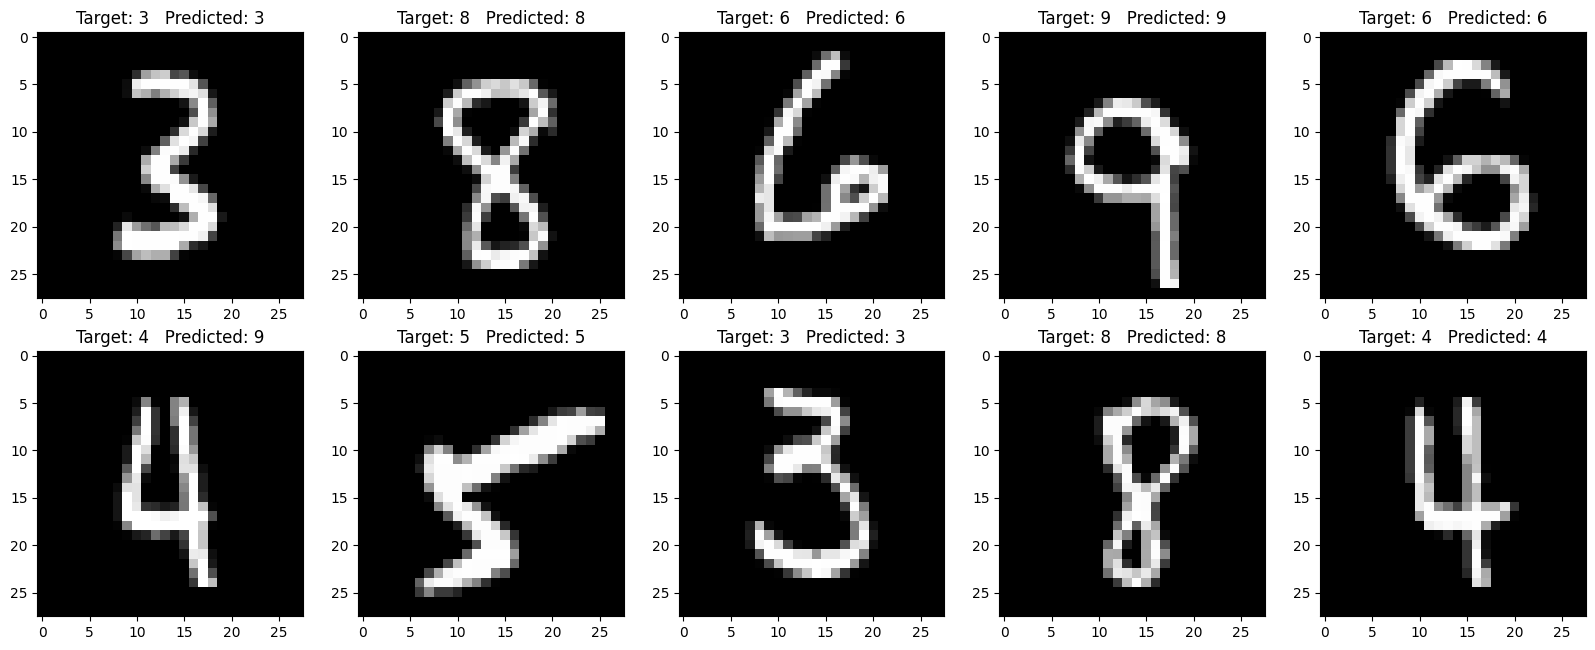

In [188]:
prediction = model.predict(X_val)
plot_predictions(X_val, y_val, prediction, n_plots=10, figsize=[20,20])

In [189]:
print(f'Final accuracy w/ X_val: {np.mean(prediction==y_val)}')

Final accuracy w/ X_val: 0.9762


In [190]:
class Dense_with_biases(Layer):
    def __init__(self, n_inputs, n_outputs, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0,
                                        scale=np.sqrt(2/(n_inputs+n_outputs)),
                                        size=(n_inputs, n_outputs))
        self.biases = np.zeros(n_outputs)

    def forward(self, input):
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

In [191]:
model2 = MLP()
model2.add_layer(Dense_with_biases(784, 200))
model2.add_layer(Dense_with_biases(200, 100))
model2.add_layer(Dense_with_biases(100, 10), hidden=False)

In [192]:
train_log2, test_log2 = train_epochs(X_train, y_train, model2, X_test, y_test)

Untrained network
Train accuracy: 0.10216
Test accuracy: 0.1061


100%|██████████| 390/390 [00:04<00:00, 84.29it/s]


Epoch 1
Train accuracy: 0.91976
Test accuracy: 0.9202


100%|██████████| 390/390 [00:03<00:00, 124.19it/s]


Epoch 2
Train accuracy: 0.94632
Test accuracy: 0.9462


100%|██████████| 390/390 [00:03<00:00, 106.34it/s]


Epoch 3
Train accuracy: 0.95846
Test accuracy: 0.955


100%|██████████| 390/390 [00:04<00:00, 80.89it/s] 


Epoch 4
Train accuracy: 0.96818
Test accuracy: 0.9628


100%|██████████| 390/390 [00:03<00:00, 120.27it/s]


Epoch 5
Train accuracy: 0.97282
Test accuracy: 0.9658


100%|██████████| 390/390 [00:03<00:00, 119.49it/s]


Epoch 6
Train accuracy: 0.97598
Test accuracy: 0.9676


100%|██████████| 390/390 [00:04<00:00, 82.71it/s] 


Epoch 7
Train accuracy: 0.98124
Test accuracy: 0.9711


100%|██████████| 390/390 [00:03<00:00, 119.75it/s]


Epoch 8
Train accuracy: 0.98314
Test accuracy: 0.9729


100%|██████████| 390/390 [00:03<00:00, 112.05it/s]


Epoch 9
Train accuracy: 0.98598
Test accuracy: 0.9749


100%|██████████| 390/390 [00:04<00:00, 90.76it/s] 


Epoch 10
Train accuracy: 0.98676
Test accuracy: 0.9742


100%|██████████| 390/390 [00:03<00:00, 124.10it/s]


Epoch 11
Train accuracy: 0.98964
Test accuracy: 0.9764


100%|██████████| 390/390 [00:04<00:00, 81.97it/s]


Epoch 12
Train accuracy: 0.99028
Test accuracy: 0.9772


100%|██████████| 390/390 [00:03<00:00, 124.12it/s]


Epoch 13
Train accuracy: 0.9915
Test accuracy: 0.9753


100%|██████████| 390/390 [00:03<00:00, 112.45it/s]


Epoch 14
Train accuracy: 0.99306
Test accuracy: 0.9769


100%|██████████| 390/390 [00:04<00:00, 79.96it/s] 


Epoch 15
Train accuracy: 0.99386
Test accuracy: 0.9781


100%|██████████| 390/390 [00:03<00:00, 121.30it/s]


Epoch 16
Train accuracy: 0.99584
Test accuracy: 0.9788


100%|██████████| 390/390 [00:03<00:00, 124.76it/s]


Epoch 17
Train accuracy: 0.99512
Test accuracy: 0.9781


100%|██████████| 390/390 [00:04<00:00, 80.52it/s] 


Epoch 18
Train accuracy: 0.99584
Test accuracy: 0.9774


100%|██████████| 390/390 [00:03<00:00, 125.03it/s]


Epoch 19
Train accuracy: 0.99722
Test accuracy: 0.9772


100%|██████████| 390/390 [00:03<00:00, 122.64it/s]


Epoch 20
Train accuracy: 0.9977
Test accuracy: 0.9787


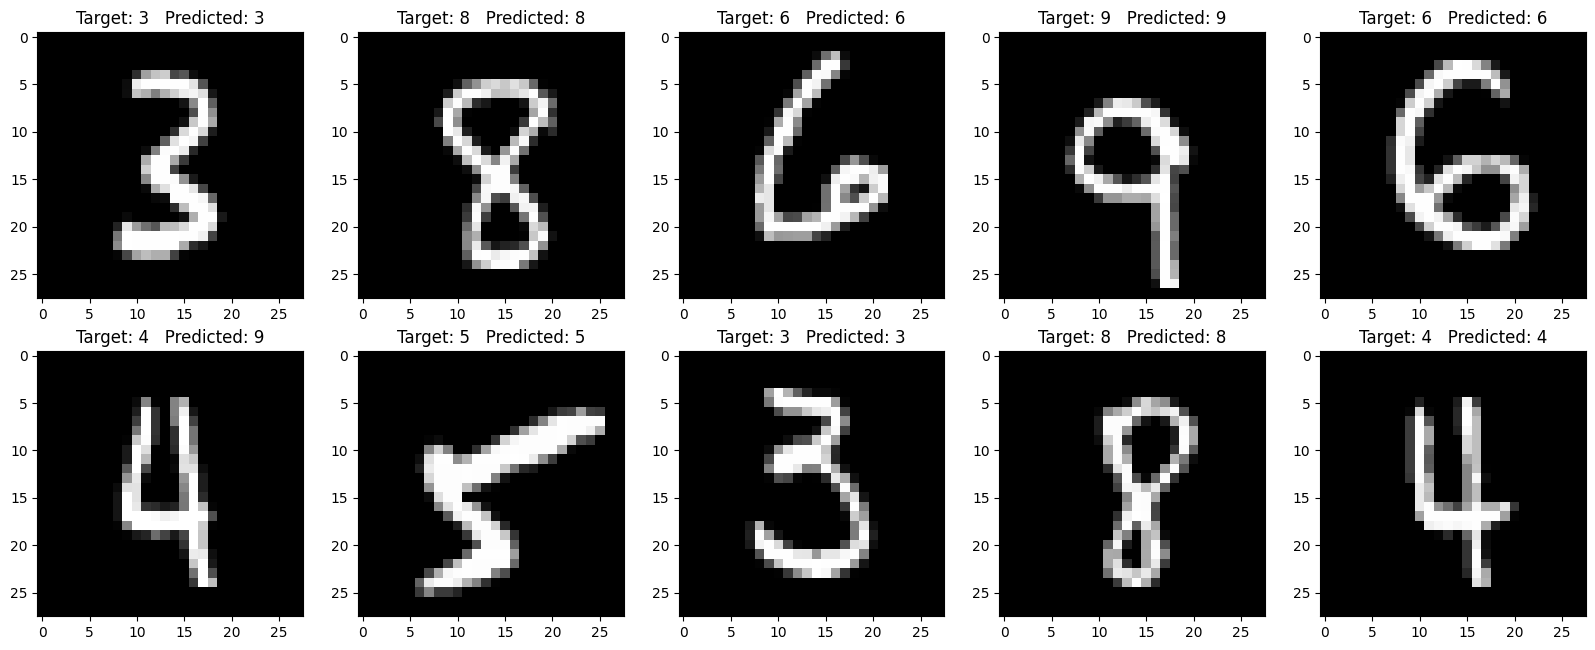

In [193]:
prediction2 = model2.predict(X_val)
plot_predictions(X_val, y_val, prediction2, n_plots=10, figsize=[20,20])

In [194]:
print(f'Final accuracy w/ X_val: {np.mean(prediction2==y_val)}')

Final accuracy w/ X_val: 0.9787


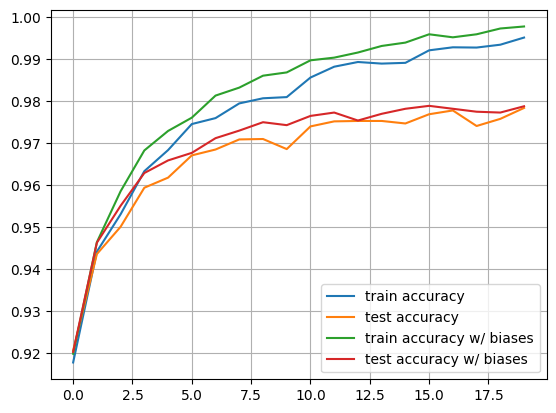

In [195]:
plt.plot(train_log,label='train accuracy')
plt.plot(test_log,label='test accuracy')
plt.plot(train_log2,label='train accuracy w/ biases')
plt.plot(test_log2,label='test accuracy w/ biases')
plt.legend(loc='best')
plt.grid()
plt.show()

##References
https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9<br/>
https://www.youtube.com/watch?v=0oWnheK-gGk<br/>
https://www.kaggle.com/code/vitorgamalemos/multilayer-perceptron-from-scratch/notebook